In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

In [2]:
df = pd.read_csv('text_emotion.csv')

# 1 - Analyse du dataset

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


In [4]:
df.shape

(40000, 4)

In [5]:
df.groupby('sentiment').count().sort_values(by = 'tweet_id')['tweet_id']

sentiment
anger          110
boredom        179
enthusiasm     759
empty          827
hate          1323
relief        1526
fun           1776
surprise      2187
love          3842
sadness       5165
happiness     5209
worry         8459
neutral       8638
Name: tweet_id, dtype: int64

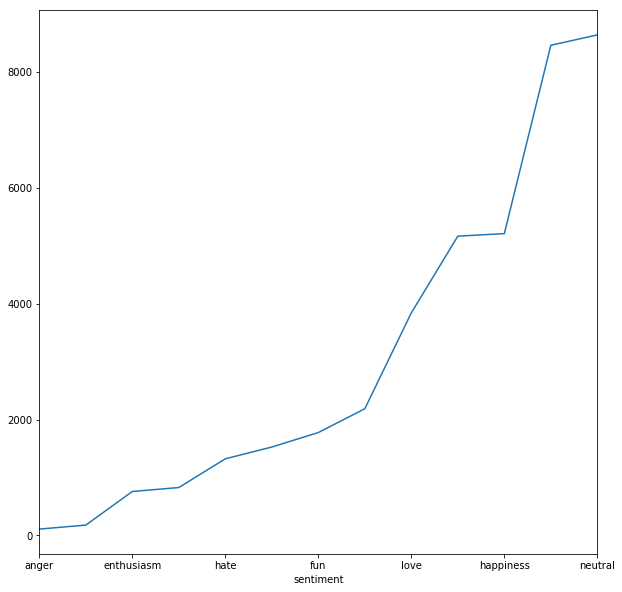

In [6]:
df.groupby('sentiment').count().sort_values(by = 'tweet_id')['tweet_id'].plot(figsize=(10,10))
plt.show()

We here have an unbalanced Dataset.

Emphasis will need to be put on unrepresented labels.

In [7]:
import spacy
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)
nlp = spacy.load("en_core_web_sm")

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Some Cleaning First

In [8]:
def remove_digits(string):
    """
    Remove digits from a string
    :param string: a string
    :return: the string without the digits
    """
    result = ''.join([i for i in string if not i.isdigit()])
    return result

In [9]:
def reduce_word_exaggeration(comment_string):
    """
    Reduces word exaggeration such as 'veeeeery' to 'veery' 
    :param comment_string: string containing the review
    :return: cleaned review string
    """
    exaggeration = re.compile(r"(.)\1{2,}")
    return exaggeration.sub(r"\1\1", comment_string)

In [10]:
def raw_to_tokens(raw_string, spacy_nlp):
    """
    cleaning pipeline to be called on each review.
    :param comment_string: string containing the review, and spaCy nlp model.
    :return: cleaned review string
    """
    string = raw_string.lower()
        
    string = remove_digits(string)
    
    string = reduce_word_exaggeration(string)
    
    spacy_tokens = spacy_nlp(string)
    
    # Remove ponctuation, stop words, and '  ':    
    string_tokens = [token.orth_ for token in spacy_tokens if not token.is_punct and not token.is_stop and not token.orth_ == '  ']
    
    clean_string = " ".join(string_tokens)
    
    return clean_string

In [11]:
import spacy
from collections import Counter

In [12]:
df = pd.read_csv('df_preprocessed_2.csv', index_col=0)
df.dropna(subset = ['content_clean'], axis = 0, inplace = True)

In [13]:
lists_of_words = [content.split() for content in df.content_clean.values]
list_of_words = [word for sublist in lists_of_words for word in sublist]
word_freq = Counter(list_of_words)
word_freq.most_common(10)

[('day', 3185),
 ('good', 2331),
 ('like', 1936),
 ('got', 1848),
 ('today', 1644),
 ('work', 1629),
 ('love', 1627),
 ('going', 1571),
 ('nt', 1505),
 ('happy', 1480)]

In [14]:
for sentiment in df.sentiment.unique():
    df_subset_sentiment = df.loc[df.sentiment == sentiment]
    lists_of_words = [content.split() for content in df_subset_sentiment.content_clean.values]
    list_of_words = [word for sublist in lists_of_words for word in sublist]
    word_freq = Counter(list_of_words)
    word_freq.most_common(10)
    print('Most common words for sentiment: {}: \n {}'.format(sentiment, word_freq.most_common(10)))

Most common words for sentiment: empty: 
 [('bored', 38), ('work', 37), ('nt', 37), ('got', 33), ('day', 33), ('m', 29), ('today', 29), ('home', 27), ('like', 27), ('twitter', 26)]
Most common words for sentiment: sadness: 
 [('sad', 384), ('day', 356), ('miss', 343), ('work', 329), ('today', 283), ('like', 278), ('nt', 277), ('got', 262), ('m', 250), ('going', 216)]
Most common words for sentiment: enthusiasm: 
 [('good', 55), ('want', 44), ('day', 42), ('today', 37), ('got', 37), ('work', 35), ('like', 34), ('new', 34), ('going', 33), ('u', 31)]
Most common words for sentiment: neutral: 
 [('day', 424), ('good', 363), ('work', 337), ('like', 337), ('going', 314), ('got', 309), ('today', 280), ('know', 273), ('nt', 266), ('time', 256)]
Most common words for sentiment: worry: 
 [('like', 454), ('got', 453), ('nt', 449), ('day', 443), ('good', 394), ('work', 393), ('going', 384), ('today', 374), ('know', 358), ('m', 340)]
Most common words for sentiment: surprise: 
 [('day', 132), ('oh'

# Featuring

Here we typically wnat to use a representation of words that such as TF-IDF.

We can apply it on the original content, but it is also recommended to apply it on the cleaned data.

For sentiment analysis, it ill also be interesting to try and only use adjectives.

In [15]:
# Adds some complexity (usefull ?)
def get_adjectives(content):
    content_adj = [token.orth_ for token in nlp(content) if token.pos_ == "ADJ"]
    return " ".join(content_adj)

No time to run it here:

To avoid data leakage, we need to perform next feature engineering after train/test split.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.content_clean, df.sentiment, test_size=0.20, random_state=1)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_1000 = TfidfVectorizer(
    max_df=0.1,
    max_features = 1000,
    strip_accents = 'ascii',
    analyzer = 'word')

vectorizer_2500 = TfidfVectorizer(
    max_df=0.1,
    max_features = 2500,
    strip_accents = 'ascii',
    analyzer = 'word')

In [18]:
X_train_1000 = vectorizer_1000.fit_transform(X_train).todense()
X_test_1000 = vectorizer_1000.transform(X_test).todense()

X_train_2500 = vectorizer_2500.fit_transform(X_train).todense()
X_test_2500 = vectorizer_2500.transform(X_test).todense()

Let's look at the number of features given by tf idf

In [19]:
X_train_1000.shape

(31969, 1000)

In [20]:
X_train_2500.shape

(31969, 2500)

As the TF IDF representation is very sparse, we can use a dimension reduction method.
It is actually too long to run.


from sklearn.decomposition import PCA
pca = PCA(n_components=1000)

# Classification

Let's use a XGBoost model, that can well handel sparse data, and which provides a convenient sample_weight parameter that will help us deal with class imbalance.

In [21]:
mapping = df.groupby('sentiment').count().sort_values(by = 'tweet_id')['tweet_id']
mapping = mapping.apply(lambda x : 100/x)
mapping = mapping.to_dict()
mapping

{'anger': 0.9090909090909091,
 'boredom': 0.5586592178770949,
 'enthusiasm': 0.13175230566534915,
 'empty': 0.12121212121212122,
 'hate': 0.07564296520423601,
 'relief': 0.0655307994757536,
 'fun': 0.05630630630630631,
 'surprise': 0.045829514207149404,
 'love': 0.026028110359187923,
 'sadness': 0.019372336303758234,
 'happiness': 0.019201228878648235,
 'worry': 0.011830119484206791,
 'neutral': 0.011603620329542817}

In [22]:
sample_weight = pd.DataFrame(y_train).replace(mapping)
sample_weight['sentiment']

36861    0.019372
27157    0.065531
38264    0.019201
8537     0.011604
37527    0.011604
           ...   
7825     0.075643
32542    0.011604
5203     0.011604
12187    0.011830
33034    0.011604
Name: sentiment, Length: 31969, dtype: float64

In [23]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {'objective':['multi:softmax'],
              'n_estimators':[3, 7, 12],
              'max_depth': [3, 5]}

xgb_clf = xgb.XGBClassifier()

clf = GridSearchCV(
    xgb_clf,
    parameters,
    scoring = 'f1_weighted',
    cv = 3,
    return_train_score = True,
    verbose = 3, 
    n_jobs=3)


search = clf.fit(X_train_1000, y_train, eval_set=[(X_train_1000, y_train), (X_test_1000, y_test)], sample_weight = sample_weight['sentiment'])
evals_result = search.cv_results_
pd.DataFrame(evals_result)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed: 53.3min finished
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-merror:0.747099	validation_1-merror:0.740148
[1]	validation_0-merror:0.747818	validation_1-merror:0.741649
[2]	validation_0-merror:0.746442	validation_1-merror:0.740273
[3]	validation_0-merror:0.747224	validation_1-merror:0.741023
[4]	validation_0-merror:0.747818	validation_1-merror:0.740648
[5]	validation_0-merror:0.747067	validation_1-merror:0.740273
[6]	validation_0-merror:0.75054	validation_1-merror:0.743526
[7]	validation_0-merror:0.756983	validation_1-merror:0.747654
[8]	validation_0-merror:0.756764	validation_1-merror:0.747779
[9]	validation_0-merror:0.757077	validation_1-merror:0.74828
[10]	validation_0-merror:0.759548	validation_1-merror:0.750156
[11]	validation_0-merror:0.759548	validation_1-merror:0.749906


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,112.482367,0.161901,4.425345,0.042389,3,3,multi:softmax,"{'max_depth': 3, 'n_estimators': 3, 'objective...",0.199447,0.146221,0.202113,0.182596,0.025741,6,0.202445,0.146149,0.211283,0.186626,0.028848
1,242.037870,1.000123,4.265003,0.125345,3,7,multi:softmax,"{'max_depth': 3, 'n_estimators': 7, 'objective...",0.204417,0.150413,0.199669,0.184836,0.024415,5,0.206863,0.150114,0.209676,0.188884,0.027439
2,379.176980,0.647166,4.244648,0.286854,3,12,multi:softmax,"{'max_depth': 3, 'n_estimators': 12, 'objectiv...",0.210573,0.159215,0.212466,0.194087,0.024668,1,0.214228,0.160410,0.223871,0.199503,0.027922
3,140.583703,0.546380,4.139387,0.127006,7,3,multi:softmax,"{'max_depth': 7, 'n_estimators': 3, 'objective...",0.201925,0.146981,0.129174,0.159368,0.030966,9,0.210014,0.153830,0.138204,0.167349,0.030836
4,316.213172,3.757035,4.143065,0.188420,7,7,multi:softmax,"{'max_depth': 7, 'n_estimators': 7, 'objective...",0.203158,0.155619,0.200842,0.186542,0.021884,4,0.211292,0.161717,0.212574,0.195194,0.023678
5,532.488395,1.546594,4.272064,0.103683,7,12,multi:softmax,"{'max_depth': 7, 'n_estimators': 12, 'objectiv...",0.202467,0.161870,0.210296,0.191545,0.021224,2,0.213559,0.165922,0.224709,0.201397,0.025494
6,187.580900,1.135378,4.107017,0.086813,12,3,multi:softmax,"{'max_depth': 12, 'n_estimators': 3, 'objectiv...",0.191040,0.142282,0.198026,0.177117,0.024795,8,0.201802,0.153298,0.207456,0.187519,0.024308
7,424.159693,2.318401,4.099035,0.202259,12,7,multi:softmax,"{'max_depth': 12, 'n_estimators': 7, 'objectiv...",0.201374,0.145283,0.200747,0.182471,0.026294,7,0.213232,0.157655,0.212942,0.194610,0.026131
8,721.038869,1.711363,3.310483,0.616027,12,12,multi:softmax,"{'max_depth': 12, 'n_estimators': 12, 'objecti...",0.202931,0.157849,0.210094,0.190293,0.023124,3,0.218440,0.168050,0.225316,0.203935,0.025530


In [27]:
parameters = {'objective':['multi:softmax'],
              'n_estimators':[3, 7, 12],
              'max_depth': [3, 7, 12]}

xgb_clf = xgb.XGBClassifier()

clf = GridSearchCV(
    xgb_clf,
    parameters,
    scoring = 'f1_weighted',
    cv = 3,
    return_train_score = True,
    verbose = 3, 
    n_jobs=3)


search = clf.fit(X_train_2500, y_train, eval_set=[(X_train_2500, y_train), (X_test_2500, y_test)], sample_weight = sample_weight['sentiment'])
evals_result = search.cv_results_
pd.DataFrame(evals_result)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed: 137.6min finished
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-merror:0.747255	validation_1-merror:0.739897
[1]	validation_0-merror:0.746755	validation_1-merror:0.739522
[2]	validation_0-merror:0.749195	validation_1-merror:0.741524
[3]	validation_0-merror:0.750477	validation_1-merror:0.742274
[4]	validation_0-merror:0.750196	validation_1-merror:0.741774
[5]	validation_0-merror:0.750258	validation_1-merror:0.740773
[6]	validation_0-merror:0.749601	validation_1-merror:0.740148
[7]	validation_0-merror:0.751697	validation_1-merror:0.7424
[8]	validation_0-merror:0.751165	validation_1-merror:0.7424
[9]	validation_0-merror:0.754137	validation_1-merror:0.743901
[10]	validation_0-merror:0.750321	validation_1-merror:0.741524
[11]	validation_0-merror:0.750633	validation_1-merror:0.741899


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,300.189172,3.545308,11.687829,0.213794,3,3,multi:softmax,"{'max_depth': 3, 'n_estimators': 3, 'objective...",0.210664,0.210529,0.200193,0.207130,0.004904,5,0.208727,0.213127,0.211424,0.211093,0.001811
1,568.273706,2.971035,11.440419,0.170469,3,7,multi:softmax,"{'max_depth': 3, 'n_estimators': 7, 'objective...",0.213724,0.213771,0.203416,0.210304,0.004870,4,0.213617,0.214397,0.215375,0.214463,0.000719
2,950.223689,1.634732,10.733769,0.186247,3,12,multi:softmax,"{'max_depth': 3, 'n_estimators': 12, 'objectiv...",0.218182,0.213668,0.211333,0.214395,0.002843,1,0.219146,0.214267,0.226331,0.219914,0.004955
3,357.884498,2.505202,10.785941,0.132882,7,3,multi:softmax,"{'max_depth': 7, 'n_estimators': 3, 'objective...",0.219453,0.214686,0.199814,0.211320,0.008364,3,0.221999,0.222965,0.213564,0.219509,0.004223
4,798.507400,3.191034,10.718282,0.834017,7,7,multi:softmax,"{'max_depth': 7, 'n_estimators': 7, 'objective...",0.216510,0.215296,0.202533,0.211447,0.006322,2,0.221280,0.223682,0.219285,0.221416,0.001798
5,1314.524730,4.255630,10.784820,0.155356,7,12,multi:softmax,"{'max_depth': 7, 'n_estimators': 12, 'objectiv...",0.221255,0.160292,0.212826,0.198128,0.026972,6,0.227809,0.167961,0.231393,0.209054,0.029094
6,469.983015,1.217408,10.765334,0.348389,12,3,multi:softmax,"{'max_depth': 12, 'n_estimators': 3, 'objectiv...",0.216899,0.142451,0.196225,0.185196,0.031379,9,0.218686,0.155736,0.209616,0.194679,0.027785
7,1144.055695,6.086999,14.245700,0.834904,12,7,multi:softmax,"{'max_depth': 12, 'n_estimators': 7, 'objectiv...",0.212936,0.147702,0.202288,0.187646,0.028575,8,0.217688,0.159704,0.217448,0.198280,0.027277
8,1955.724897,10.534521,10.747977,0.275600,12,12,multi:softmax,"{'max_depth': 12, 'n_estimators': 12, 'objecti...",0.214370,0.154546,0.217299,0.195407,0.028915,7,0.224553,0.166892,0.234358,0.208601,0.029763


In [32]:
vectorizer_5000 = TfidfVectorizer(
    max_df=0.1,
    max_features = 5000,
    strip_accents = 'ascii',
    analyzer = 'word')

X_train_5000 = vectorizer_5000.fit_transform(X_train).todense()
X_test_5000 = vectorizer_5000.transform(X_test).todense()

parameters = {'objective':['multi:softmax'],
              'n_estimators':[30],
              'max_depth': [5]}

xgb_clf = xgb.XGBClassifier()

clf = GridSearchCV(
    xgb_clf,
    parameters,
    scoring = 'f1_weighted',
    cv = 3,
    return_train_score = True,
    verbose = 4, 
    n_jobs=4)


search = clf.fit(X_train_5000, y_train, eval_set=[(X_train_5000, y_train), (X_test_5000, y_test)], sample_weight = sample_weight['sentiment'])
evals_result = search.cv_results_
pd.DataFrame(evals_result)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 94.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 94.2min finished
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-merror:0.75251	validation_1-merror:0.742775
[1]	validation_0-merror:0.752166	validation_1-merror:0.744026
[2]	validation_0-merror:0.755357	validation_1-merror:0.745652
[3]	validation_0-merror:0.753887	validation_1-merror:0.746778
[4]	validation_0-merror:0.751853	validation_1-merror:0.746528
[5]	validation_0-merror:0.753761	validation_1-merror:0.747279
[6]	validation_0-merror:0.753949	validation_1-merror:0.748655
[7]	validation_0-merror:0.757046	validation_1-merror:0.752533
[8]	validation_0-merror:0.757234	validation_1-merror:0.752784
[9]	validation_0-merror:0.75398	validation_1-merror:0.749656
[10]	validation_0-merror:0.75348	validation_1-merror:0.750907
[11]	validation_0-merror:0.752698	validation_1-merror:0.748655
[12]	validation_0-merror:0.755388	validation_1-merror:0.752158
[13]	validation_0-merror:0.755482	validation_1-merror:0.752158
[14]	validation_0-merror:0.756264	validation_1-merror:0.753659
[15]	validation_0-merror:0.756107	validation_1-merror:0.753409
[16]	

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5560.207621,30.461314,15.58864,3.206189,5,30,multi:softmax,"{'max_depth': 5, 'n_estimators': 30, 'objectiv...",0.220374,0.159686,0.213599,0.197889,0.027152,1,0.230692,0.172469,0.232211,0.211791,0.027812


Next Steps:


- Debug XGBoost
- Take time to run and fine tune algorithme
- Try different Algorithmes for classification
- Compare performance when using PCA, Adjectives, more features after TF-IDF.
- Improve Cleaning.